# Model predictive control is almost optimal for restless bandits: figures

This notebook contains all the code needed to reproduce the figures from the paper "Model predictive control is almost optimal for restless bandits" accepted at COLT 2025. 

It also contains other plots that might be useful to understand the code. 

The code uses "numpy", "matplotlib" and "pulp" to run most figures, plus the additional "ternary" package for the ternary plot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bandit_lp
import strategies
import os

In [2]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
COLOR_FTVA = default_colors[1]
COLOR_LPUP = default_colors[0]
COLOR_LPPR = default_colors[2]

In [3]:
def mean_confinterval(values):
    """
    Compute the mean and a confidence intervals (+/- 2 std/sqrt(N))
    Inputs: 
    - values can be 1D of size N or 2D array (of size Kx(N-1))

    Return mean, conf where (mean,conf) are two values or two arrays of size K
    """
    array = np.array(values)
    if len(array.shape) == 1:
        return np.mean(array), 2*np.std(array)/np.sqrt(len(array)-1)
    else:
        assert len(array.shape) == 2, "Array must be 1D or 2D"
        return np.mean(array, 1), 2*np.std(array, 1)/np.sqrt(array.shape[1]-1)

We first define an instance that contains the counter-example. 

In [4]:
bandit = bandit_lp.BanditCounterExample()
alpha = 0.5
g_star, y_star = bandit.relaxed_lp_average_reward(alpha)[0:2]
x_star = np.sum(y_star, 1)

order_from_hong23 = strategies.PriorityStrategy([1, 2, 3, 0, 7, 6, 5, 4], alpha)
lp_update5 = strategies.LPupdateStrategy(bandit, alpha, 5)
lp_update10 = strategies.LPupdateStrategy(bandit, alpha, 10)
lp_update20 = strategies.LPupdateStrategy(bandit, alpha, 20)
lp_priority = strategies.LPPriorityStrategy(bandit, alpha)
ftva = strategies.FTVA_Strategy(bandit, alpha)
whittle_strat = strategies.WhittleIndexStrategy(bandit, alpha)
lp_update5.hashname()

'd56728d1d4'

In [5]:
x_init = [1/3., 2/3., 0, 0, 0, 0, 0 , 0] # initial state
time = 500
gain_up5, x_update5, rewards_up5, y_values5 = strategies.simulate(bandit, lp_update5, x_init, N=100, time=time, seed=2)
gain_up10, x_update10, rewards_up10, y_values10 = strategies.simulate(bandit, lp_update10, x_init, N=100, time=time, seed=2)
gain_up20, x_update20, rewards_up20, y_values20  = strategies.simulate(bandit, lp_update20, x_init, N=100, time=time, seed=2)
gain_hong23, x_hong23, rewards_hong23, y_values_h23  = strategies.simulate(bandit, order_from_hong23, x_init, N=100, time=time, seed=1)
gain_prio, x_prio, rewards_prio, y_values_prio = strategies.simulate(bandit, lp_priority, x_init, N=100, time=time, seed=0)
gain_ftva, x_ftva, rewards_ftva, y_values_ftva = strategies.simulate(bandit, ftva, x_init, N=100, time=time, seed=0)

In [6]:
len(lp_update10.computed_y)

0

Text(0, 0.5, 'Instantaneous reward')

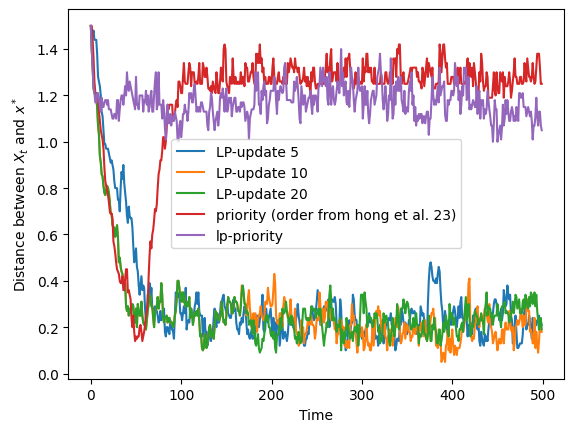

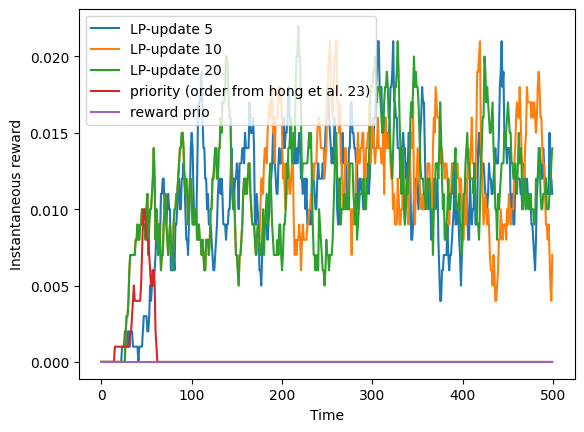

In [7]:
plt.plot(np.sum(np.abs(x_update5 - x_star), 1), label='LP-update 5')
plt.plot(np.sum(np.abs(x_update10 - x_star), 1), label='LP-update 10')
plt.plot(np.sum(np.abs(x_update20 - x_star), 1), label='LP-update 20')
plt.plot(np.sum(np.abs(x_hong23 - x_star), 1), label='priority (order from hong et al. 23)')
plt.plot(np.sum(np.abs(x_prio - x_star), 1), label='lp-priority')
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'Distance between $X_t$ and $x^*$')

plt.figure()
plt.plot(rewards_up5, label='LP-update 5')
plt.plot(rewards_up10, label='LP-update 10')
plt.plot(rewards_up20, label='LP-update 20')
plt.plot(rewards_hong23, label='priority (order from hong et al. 23)')
plt.plot(rewards_prio, label='reward prio')
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'Instantaneous reward')

/var/folders/fz/3nn_5spd1pv4nnt3rmgx_z0c0000gn/T/ipykernel_45375/1651787212.py:12: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(3,3))
/var/folders/fz/3nn_5spd1pv4nnt3rmgx_z0c0000gn/T/ipykernel_45375/1651787212.py:15: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(3,3))


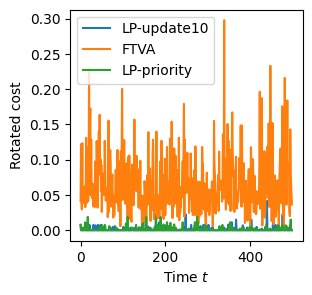

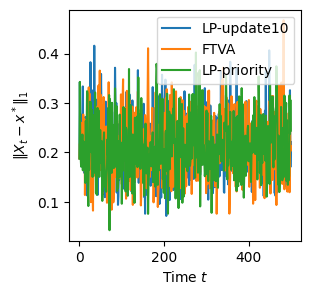

In [8]:
# We do not plot (y_values_h23, 'Priority from hong et al. 23'),
myBandits = [bandit_lp.BanditCounterExample(), bandit_lp.BanditRandom(8, 2, seed=3)]
myNames = ['counter-example-Hong', 'random-example3']

for bandit, name in zip(myBandits, myNames):
    x_init = np.ones(8)/8
    order_from_hong23 = strategies.PriorityStrategy([1, 2, 3, 0, 7, 6, 5, 4], alpha)
    lp_update10 = strategies.LPupdateStrategy(bandit, alpha, 10)
    lp_priority = strategies.LPPriorityStrategy(bandit, alpha)
    ftva = strategies.FTVA_Strategy(bandit, alpha)
    for N in [100]:
        plt.figure(1, figsize=(3,3))
        plt.plot([])
        plt.clf()
        plt.figure(2, figsize=(3,3))
        plt.plot([])
        plt.clf()
        for policy,label in [(lp_update10, 'LP-update10'), (ftva, 'FTVA'), (lp_priority, 'LP-priority')]:
            y_values = strategies.simulate(bandit, policy, x_init, N=N, time=time, seed=2)[3]
            plt.figure(1)
            plt.plot(bandit.rotated_cost(y_values) , label=label)
            plt.legend()
            plt.xlabel('Time $t$')
            plt.ylabel(r'Rotated cost')
            plt.savefig('figs/{}-rotated-cost_N{}.pdf'.format(name, N), bbox_inches='tight')
            plt.figure(2)
            plt.plot(bandit.distance_to_x_star(y=y_values), label=label)
            plt.legend()
            plt.xlabel('Time $t$')
            plt.ylabel(r'$\|X_t - x^*\|_1$')
            plt.savefig('figs/{}-distance_N{}.pdf'.format(name, N), bbox_inches='tight')

## Average gains as a function of N

As a function of the update parameters, we do not see much difference.

In [9]:
np.mean(rewards_up5[100:]), np.mean(rewards_up10[100:]), np.mean(rewards_up20[100:])

(np.float64(0.012132500000000001),
 np.float64(0.012190000000000003),
 np.float64(0.011940000000000004))

Now as a function of $N$, we would probably need to compute confidence intervals to see something. 

**Note**: this taks time (and the confidence intervals seem quite poor)

In [10]:
x_init = [1/3., 2/3., 0, 0, 0, 0, 0 , 0] # initial state
myBandits = [bandit_lp.BanditCounterExample(), bandit_lp.BanditRandom(8, 2, seed=1), bandit_lp.BanditRandom(8, 2, seed=3)]
myNames = ['counter-example-Hong', 'random-example1', 'random-example3']
gains = dict([])

for bandit in myBandits:
    print('lp-bound:', bandit.relaxed_lp_average_reward(alpha)[0])

    lp_update10 = strategies.LPupdateStrategy(bandit, alpha, 10)
    lp_priority = strategies.LPPriorityStrategy(bandit, alpha)
    whittle_index = strategies.WhittleIndexStrategy(bandit, alpha)
    FTVA = strategies.FTVA_Strategy(bandit, alpha)
    
    myN = [10, 20, 50, 100, 200, 500]
    print('N\t LPup\tLPup2\tFTVA\tFTVA', end='\n')
    for N in myN:
        print('{} \t'.format(N), end='')
        for j, strategy in enumerate([lp_update10, FTVA, lp_priority, whittle_index]):
            for i in range(10):
                gain = np.mean(strategies.simulate(bandit, strategy, x_init, N=N, time=1000, seed = i)[2][100:])
                print('{:1.5f}'.format(gain), end='\t')
                if (bandit.hashname(), N, j) in gains:
                    gains[(bandit.hashname(), N, j)].append(gain)
                else:
                    gains[(bandit.hashname(), N, j)] = [gain]
        print()

lp-bound: 0.0125
N	 LPup	LPup2	FTVA	FTVA
10 	0.00874	0.00996	0.01097	0.01012	0.01300	0.00951	0.01041	0.00949	0.01056	0.00836	0.00819	0.00843	0.00810	0.00772	0.00868	0.00840	0.00743	0.00779	0.00757	0.00768	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00971	0.01040	0.00930	0.00972	0.01004	0.00978	0.00908	0.00988	0.00902	0.00828	
20 	0.01171	0.01175	0.01081	0.01091	0.01079	0.01200	0.01152	0.01039	0.01078	0.01052	0.00898	0.00904	0.00845	0.00882	0.00914	0.00983	0.00882	0.00968	0.00827	0.00912	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.01049	0.01064	0.01164	0.01149	0.01083	0.01063	0.01077	0.01029	0.01049	0.01144	
50 	0.01134	0.01210	0.01195	0.01060	0.01155	0.01157	0.01166	0.01178	0.01098	0.01209	0.01003	0.00947	0.01042	0.01115	0.00960	0.01023	0.01030	0.01002	0.01011	0.00993	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.00000	0.01187	0.01134	0.01095	0.01058	0.01134	0.01042	0.01036	0.01112	0

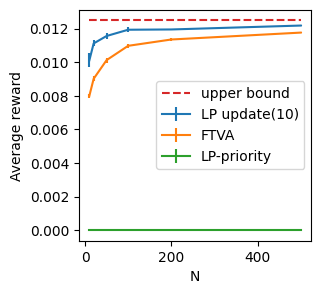

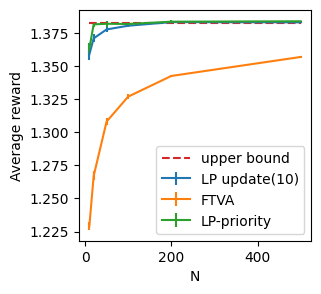

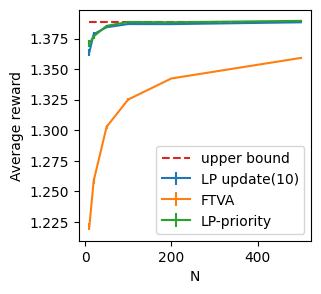

In [11]:
for bandit, name in zip(myBandits, myNames):
    plt.figure(figsize=(3,3))
    g_star, y_star = bandit.relaxed_lp_average_reward(0.5)[0:2]
    for i, strat in enumerate(['LP update(10)', 'FTVA', 'LP-priority']):
        my_gains = np.array([gains[(bandit.hashname(), N, i)] for N in myN])
        means = np.mean(my_gains, 1)
        err = np.std(my_gains, 1)/np.sqrt(my_gains.shape[1]-1)
        #err = (np.max(my_gains, 1)-np.min(my_gains,1))/2
        #[(max(gains[(N,i)])-min(gains[(N,i)]))/2 for N in myN]
        plt.errorbar(myN, means, err, label=strat)
    plt.plot(myN, np.ones(len(myN))*g_star,'--', label='upper bound')
    plt.legend()
    plt.xlabel('N')
    plt.ylabel('Average reward')
    plt.savefig('figs/{}_functionN.pdf'.format(name),bbox_inches='tight')

## Comparison of LP-update($\tau$) (and of LP-priority and FTVA) on randomly generated examples
For a fixed N and alpha=0.5 as before.

In [12]:
myN = [10, 30, 50, 100]
alpha=0.5
rewards = []
for N in myN:
    rewards.append([])
    for seed in range(50):
        rewards[-1].append([])
        bandit = bandit_lp.BanditRandom(8, 2, seed=seed)
        g_star = bandit.relaxed_lp_average_reward(alpha)[0]
        lp_priority = strategies.LPPriorityStrategy(bandit, alpha)
        lp_update10 = strategies.LPupdateStrategy(bandit, alpha, 10)
        lp_update5 = strategies.LPupdateStrategy(bandit, alpha, 5)
        lp_update3 = strategies.LPupdateStrategy(bandit, alpha, 3)
        lp_update1 = strategies.LPupdateStrategy(bandit, alpha, 1)
        FTVA = strategies.FTVA_Strategy(bandit, alpha)
        for i, strat in enumerate([lp_priority, lp_update3, lp_update5, lp_update10, FTVA]): #, lp_update1]):
            print('\rN={}, {}/50, {}/5, '.format(N, seed, i), end='')
            rewards[-1][-1].append(np.mean(strategies.simulate(bandit, strat, x_init, N=N, time=1000, seed=seed)[2][200:]) / g_star)
    print()
print()
rewards = np.array(rewards)

N=10, 49/50, 4/5, 
N=30, 49/50, 4/5, 
N=50, 49/50, 4/5, 
N=100, 49/50, 4/5, 



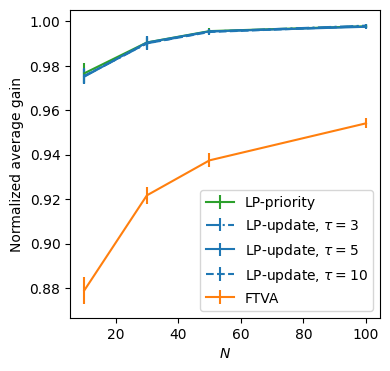

In [13]:
colors = [COLOR_LPPR,COLOR_LPUP,COLOR_LPUP,COLOR_LPUP,COLOR_FTVA,COLOR_LPUP]
linestyles = ['-','-.','-','--','-',':']
means = np.mean(rewards, 1)
myPol = [r'LP-priority', r'LP-update, $\tau=3$', r'LP-update, $\tau=5$', r'LP-update, $\tau=10$', r'FTVA'] #, r'LP-update, $\tau=1$']
plt.figure(figsize=(4,4))
for i, pol in enumerate(myPol):
    mea, err_bar = mean_confinterval(rewards[:, :, i])
    #if i == 1:
    plt.errorbar(myN, means[:, i], err_bar, ls=linestyles[i], label=pol, color=colors[i])
plt.xlabel(r'$N$')
plt.ylabel('Normalized average gain')
plt.legend()
plt.savefig('figs/gain_various_tau.pdf', bbox_inches="tight")

(array([1., 3., 3., 4., 7., 7., 6., 8., 8., 3.]),
 array([0.94639572, 0.95136171, 0.9563277 , 0.96129369, 0.96625969,
        0.97122568, 0.97619167, 0.98115766, 0.98612365, 0.99108964,
        0.99605564]),
 <BarContainer object of 10 artists>)

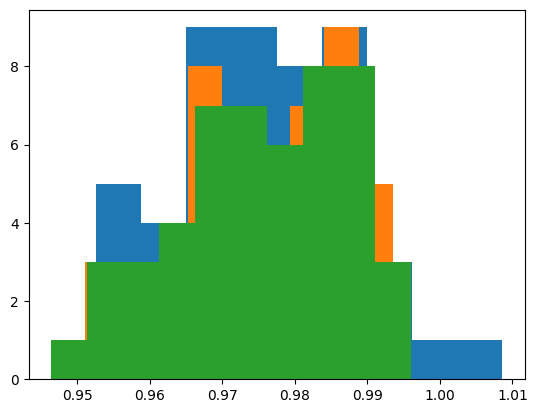

In [14]:
#plt.hist(rewards[0, :, 5])
plt.hist(rewards[0, :, 1])
plt.hist(rewards[0, :, 2])
plt.hist(rewards[0, :, 3])


## Trying a different budget $\alpha$

The result seem qualitatively similar and the sub-optimality gap does not depend much on $\alpha$.

In [15]:
means = []
myAlpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
myN = [50]
for alpha in myAlpha:
    means.append([])
    print('alpha={}\t| N=10\t\t\t|N=50'.format(alpha))
    print('ID\tbound\t|update\tLP-prio\tFTVA\t|update\tLP-prio\tFTVA\t|')
    for seed in range(50):
        means[-1].append([])
        bandit = bandit_lp.BanditRandom(8, 2, seed=seed)
        lp_priority = strategies.LPPriorityStrategy(bandit, alpha)
        lp_update = strategies.LPupdateStrategy(bandit, alpha, 10)
        FTVA = strategies.FTVA_Strategy(bandit, alpha)
        g_star = bandit.relaxed_lp_average_reward(alpha)[0]
        print('{}\t{:1.5f}'.format(seed, g_star), end ='\t|')
        for N in myN:
            means[-1][-1].append([])
            for strat in [lp_update, lp_priority, FTVA]:
                ratio = np.mean(strategies.simulate(bandit, strat, x_init, N=N, time=1000, seed=0)[2][200:])/g_star
                means[-1][-1][-1].append(ratio)
                print('{:1.4f}'.format(ratio), end='\t')
            print('|', end='')
        print()
means = np.array(means)

alpha=0.1	| N=10			|N=50
ID	bound	|update	LP-prio	FTVA	|update	LP-prio	FTVA	|
0	1.18905	|0.9970	0.9970	0.9637	|
1	1.23931	|0.9985	0.9985	0.9472	|
2	1.08602	|0.9960	0.9960	0.9768	|
3	1.20195	|0.9726	0.9716	0.9277	|
4	1.02307	|0.9963	0.9963	0.9526	|
5	0.79376	|0.9972	0.9960	0.9534	|
6	0.95728	|0.9880	0.9880	0.9596	|
7	1.55220	|0.9918	0.9918	0.9456	|
8	0.98884	|0.9947	0.9947	0.9695	|
9	1.19249	|1.0000	1.0000	0.9590	|
10	1.22099	|0.9938	0.9938	0.9419	|
11	1.94788	|0.9973	0.9973	0.9530	|
12	0.90281	|0.9925	0.9925	0.9741	|
13	1.03805	|0.9892	0.9892	0.9641	|
14	0.92662	|0.9959	1.0006	0.9562	|
15	1.16556	|0.9888	0.9880	0.9554	|
16	1.15488	|0.9962	0.9962	0.9433	|
17	1.15063	|0.9889	0.9922	0.9524	|
18	0.88363	|0.9993	0.9993	0.9662	|
19	0.56423	|0.9916	0.9916	0.9081	|
20	1.58892	|0.9922	0.9926	0.9310	|
21	0.93725	|0.9990	0.9990	0.9718	|
22	1.09131	|1.0000	1.0000	0.9696	|
23	1.16219	|0.9921	0.9921	0.9087	|
24	1.56695	|0.9982	0.9982	0.9654	|
25	2.52608	|0.9938	0.9938	0.9661	|
26	0.72137	|0.9879	0.9

In [16]:
mean = np.mean(means, 1)
conf = np.ones(mean.shape)
for i,_ in enumerate(myAlpha):
    for j,_ in enumerate(myN):
        for k in range(3):
            mean[i,j,k], conf[i,j,k] = mean_confinterval(means[i,:,j,k])

(9, 1, 3)
[0.00162931 0.00301524 0.00155519 0.00143495 0.00110067 0.00149219
 0.00225259 0.00228689 0.00278732]
[0.00172719 0.00301495 0.00212375 0.00167272 0.00121079 0.00167666
 0.00264959 0.00249135 0.00268484]
[0.00499788 0.00494162 0.00414564 0.00350327 0.00314759 0.00346834
 0.00413036 0.00471169 0.00551541]


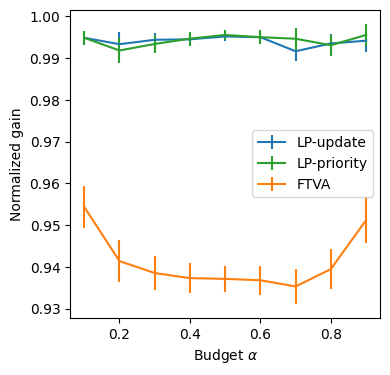

In [17]:
mean = np.mean( means, 1 ) # average among the 10 seeds
print(mean.shape)
colors = [COLOR_LPUP,COLOR_LPPR,COLOR_FTVA]
linestyles=['-',':','-.','--']
for i, N in enumerate(myN):
    plt.figure(figsize=(4,4))
    for i_pol, pol in enumerate(['LP-update', 'LP-priority', 'FTVA']):
        print(conf[:,i,i_pol])
        plt.errorbar(myAlpha, mean[:,i,i_pol], conf[:,i,i_pol], ls=linestyles[i], color=colors[i_pol], label='{}'.format(pol))
        #plt.errorbar(myAlpha, mean[:,i,i_pol], ls=linestyles[i], color=colors[i_pol], label='{}'.format(pol))
plt.legend()
plt.xlabel(r'Budget $\alpha$')
plt.ylabel('Normalized gain')
plt.savefig("figs/gain_various_alpha.pdf", bbox_inches='tight')

# Trying with a larger state-space

In [18]:
myS = [8, 20, 30, 50]
myN = [10, 30, 50, 100]
for alpha in [0.3]:
    print('alpha={}\t| N=10\t\t\t|N=30\t\t\t|N=50\t\t\t|N=100'.format(alpha))
    print('ID\tbound\t|update\tLP-prio\tFTVA\t|update\tLP-prio\tFTVA\t|update\tLP-prio\tFTVA')
    means = []
    for S in myS:
        means.append([])
        for seed in range(20):
            means[-1].append([])
            x_initial = np.zeros(S)
            x_initial[0:5] = 1/5
            bandit = bandit_lp.BanditRandom(S, 2, seed=seed)
            lp_priority = strategies.LPPriorityStrategy(bandit, alpha)
            lp_update = strategies.LPupdateStrategy(bandit, alpha, 10)
            FTVA = strategies.FTVA_Strategy(bandit, alpha)
            g_star = bandit.relaxed_lp_average_reward(alpha)[0]
            print('{}\t{:1.5f}'.format(seed, g_star), end ='\t|')
            for N in [10, 30, 50, 100]:
                means[-1][-1].append([])
                for strat in [lp_update, lp_priority, FTVA]:
                    ratio = np.mean(strategies.simulate(bandit, strat, x_initial, N=N, time=1000, seed=0)[2][200:])/g_star
                    means[-1][-1][-1].append(ratio)
                    print('{:1.4f}'.format(ratio), end='\t')
                print('|', end='')
            print()
means = np.array(means)

alpha=0.3	| N=10			|N=30			|N=50			|N=100
ID	bound	|update	LP-prio	FTVA	|update	LP-prio	FTVA	|update	LP-prio	FTVA
0	1.26300	|0.9684	0.9889	0.8935	|0.9942	0.9956	0.9450	|0.9950	0.9965	0.9523	|0.9966	0.9985	0.9663	|
1	1.45273	|0.9679	0.9351	0.8668	|0.9852	0.9767	0.9186	|0.9964	0.9950	0.9320	|0.9971	0.9950	0.9496	|
2	1.23803	|0.9827	0.9662	0.8961	|1.0090	0.9884	0.9366	|0.9813	0.9960	0.9457	|0.9940	1.0008	0.9644	|
3	1.36022	|0.9790	0.9932	0.8671	|0.9902	0.9971	0.9119	|0.9926	0.9946	0.9253	|0.9982	1.0020	0.9479	|
4	1.30715	|0.9804	0.9647	0.8634	|0.9898	0.9897	0.9163	|1.0006	0.9900	0.9291	|0.9963	0.9939	0.9465	|
5	1.10809	|0.9801	0.9779	0.8820	|0.9933	1.0002	0.9346	|0.9964	0.9940	0.9399	|0.9988	0.9990	0.9567	|
6	1.21504	|0.9835	0.9013	0.8629	|0.9773	0.9753	0.9043	|1.0014	0.9852	0.9335	|0.9963	0.9930	0.9569	|
7	1.76592	|0.9763	0.9751	0.8715	|0.9880	0.9972	0.9164	|0.9981	1.0013	0.9270	|1.0022	0.9980	0.9481	|
8	1.10742	|0.9767	0.9437	0.9018	|0.9811	0.9746	0.9361	|0.9811	0.9790	0.9512	|0.9894	0.

In [19]:
mean = np.mean(means, 1)
conf = np.ones(mean.shape)
for i,_ in enumerate(myS):
    for j,_ in enumerate(myN):
        for k in range(3):
            mean[i,j,k], conf[i,j,k] = mean_confinterval(means[i,:,j,k])

(4, 4, 3)
[0.97168705 0.9867959  0.991872   0.99680496]
[0.96136921 0.9873962  0.99145914 0.99610613]
[0.87612749 0.92243848 0.9369552  0.95388628]
[0.97672138 0.98676735 0.99365391 0.99657498]
[0.96889495 0.99181969 0.99427108 0.99623424]
[0.85765885 0.90843254 0.92809259 0.94662371]
[0.97595393 0.98308633 0.99442831 0.99657471]
[0.97022469 0.99184355 0.99497405 0.99763012]
[0.8395318  0.89390959 0.9150521  0.9385538 ]
[0.97740839 0.98568415 0.99421206 0.99864443]
[0.97213484 0.99240217 0.99503311 0.99808967]
[0.82984417 0.88456545 0.908219   0.93076996]


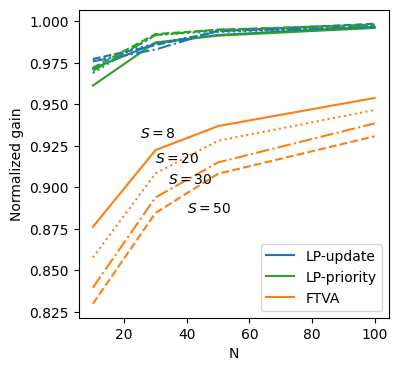

In [20]:
plt.figure(figsize=(4,4))
mean = np.mean( means, 1 ) # average among the 10 seeds
print(mean.shape)
colors = [COLOR_LPUP, COLOR_LPPR, COLOR_FTVA]
linestyles=['-',':','-.','--']
for i, S in enumerate(myS):
    for i_pol, pol in enumerate(['LP-update', 'LP-priority', 'FTVA']):
        print(mean[i,:,i_pol])
        #plt.errorbar(myN, mean[i,:,i_pol], conf[i,:,i_pol], ls=linestyles[i], color=colors[i_pol], label=('{}'.format(pol) if i==0 else ''))
        plt.plot(myN, mean[i,:,i_pol], ls=linestyles[i], color=colors[i_pol], label=('{}'.format(pol) if i==0 else ''))

plt.text(25,0.93, '$S=8$')
plt.text(30,0.915, '$S=20$')
plt.text(34,0.902, '$S=30$')
plt.text(40,0.885, '$S=50$')
plt.legend()
plt.xlabel('N')
plt.ylabel('Normalized gain')
plt.savefig("figs/gain_various_S.pdf", bbox_inches='tight')

In [21]:
alpha = 0.55
#bandit = bandit_lp.BanditRandom(8, 2, seed=seed)
bandit = bandit_lp.BanditCounterExampleYan2()
y_star = bandit.relaxed_lp_average_reward(alpha)[1]
print(y_star)
x_star = np.sum(y_star, 1)
lp_update = strategies.LPupdateStrategy(bandit, alpha, 50)
lp_prio = strategies.LPPriorityStrategy(bandit, alpha)
myX = []
myYup = []
myYprio = []
for i in range(100):
    np.random.seed(i)
    error = np.random.rand(bandit.S)
    error -= np.sum(error)/bandit.S
    my_x = x_star + error*0.01
    myX.append(my_x)
    myYup.append(lp_update.next_y(my_x))
    myYprio.append(lp_prio.next_y(my_x))


[[0.         0.33718761]
 [0.14193566 0.21281239]
 [0.30806434 0.        ]]


In [22]:
errorUP, errorPR = 0, 0
for s in range(bandit.S):
    for a in range(2):
        errorUP += np.linalg.lstsq(np.array(myX), np.array(myYup)[:,s,a], rcond=-1)[1]
        errorPR += np.linalg.lstsq(np.array(myX), np.array(myYprio)[:,s,a], rcond=-1)[1]
        #print(s, a, np.linalg.lstsq(np.array(myX), np.array(myYprio)[:,s,a], rcond=-1)[1][0])
print('total error for non-linearity:', errorUP, errorPR)

total error for non-linearity: [0.00014517] [6.13995097e-31]


In [23]:
np.max(np.abs(np.array(myYup) - np.array(myYprio)))

np.float64(0.004399447925534261)

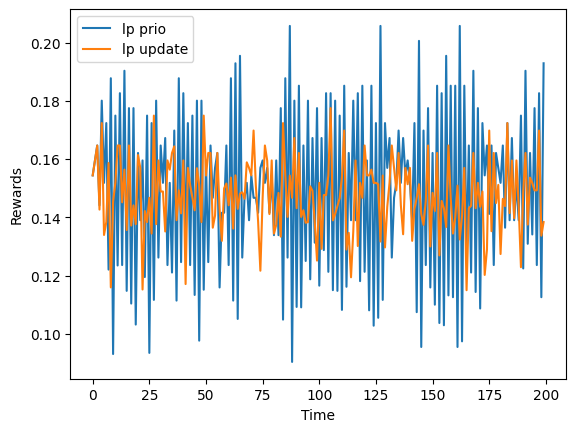

In [24]:
x_init = x_star
gain_upda, x_upda, rewards_upda, y_upda = strategies.simulate(bandit, lp_update, x_init, N=100, time=200, seed=1)
gain_prio, x_prio, rewards_prio, y_prio = strategies.simulate(bandit, lp_prio, x_init, N=100, time=200, seed=1)
plt.plot(rewards_prio, label='lp prio')
plt.plot(rewards_upda, label='lp update')
plt.xlabel('Time')
plt.ylabel('Rewards')
plt.legend()

10
20
30
50
100
200


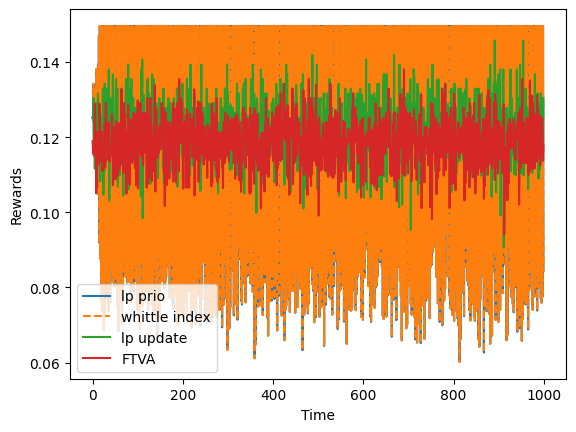

In [25]:
EXAMPLE_NUMBER = 2

alpha = .4
if EXAMPLE_NUMBER == 1:
    bandit = bandit_lp.BanditCounterExampleYan1()
else:
    bandit = bandit_lp.BanditCounterExampleYan2()
    
lp_update = strategies.LPupdateStrategy(bandit, alpha, 50)
lp_prio = strategies.LPPriorityStrategy(bandit, alpha)
whittle = strategies.WhittleIndexStrategy(bandit, alpha)
FTVA = strategies.FTVA_Strategy(bandit, alpha)

number_of_seeds = 10
x_star = np.sum(bandit.relaxed_lp_average_reward(alpha)[1], 1)
myN = [10, 20, 30, 50, 100, 200]
for N in myN:
    print(N)
    for seed in range(number_of_seeds):
        gain_upda, x_upda, rewards_upda, y_upda = strategies.simulate(bandit, lp_update, x_star, N=N, time=1000, seed=seed)
        gain_prio, x_prio, rewards_prio, y_prio = strategies.simulate(bandit, lp_prio, x_star, N=N, time=1000, seed=seed)
        gain_whittle, x_whittle, rewards_whittle, y_whittle = strategies.simulate(bandit, whittle, x_star, N=N, time=1000, seed=seed)
        gain_FTVA, x_FTVA, rewards_FTVA, y_FTVA = strategies.simulate(bandit, FTVA, x_star, N=N, time=1000, seed=seed)
plt.plot(rewards_prio, label='lp prio')
plt.plot(rewards_whittle, '--', label='whittle index')
plt.plot(rewards_upda, label='lp update')
plt.plot(rewards_FTVA, label='FTVA')
plt.xlabel('Time')
plt.ylabel('Rewards')
plt.legend()

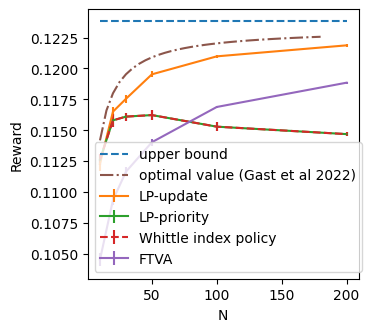

In [26]:
plt.figure(figsize=(3.5,3.5))
g_star = bandit.relaxed_lp_average_reward(alpha)[0]
lp_u, lp_u_err = mean_confinterval([[np.mean(strategies.simulate(bandit, lp_update, x_star, N=N, time=1000, seed=seed)[2][200:])
                                     for seed in range(number_of_seeds)] for N in myN])
lp_p, lp_p_err = mean_confinterval([[np.mean(strategies.simulate(bandit, lp_prio, x_star, N=N, time=1000, seed=seed)[2][200:])
                                     for seed in range(number_of_seeds)] for N in myN])
whit, whit_err = mean_confinterval([[np.mean(strategies.simulate(bandit, whittle, x_star, N=N, time=1000, seed=seed)[2][200:])
                                     for seed in range(number_of_seeds)] for N in myN])
ftv, ftv_err = mean_confinterval([[np.mean(strategies.simulate(bandit, FTVA, x_star, N=N, time=1000, seed=seed)[2][200:])
                                   for seed in range(number_of_seeds)] for N in myN])

if EXAMPLE_NUMBER == 1:
    (optimal_policy, wip), n_opt = np.load('computed_values/example1_from_yan2020.npz')['arr_0'], np.arange(10,155,5) # for example 1 
else:
    (optimal_policy, wip), n_opt = np.load('computed_values/example2_from_yan2020.npz')['arr_0'],  np.arange(10,185,5) # for example 2
#plt.plot(n_opt, wip, '-.', label='Whittle index policy (data from Yan et al 2022)')
plt.plot(myN, np.zeros(len(myN))+g_star, '--', label='upper bound')

plt.errorbar(myN, lp_u, lp_u_err, label='LP-update')
plt.errorbar(myN, lp_p, lp_p_err, label='LP-priority')
plt.errorbar(myN, whit, whit_err, ls='--', label='Whittle index policy')
plt.errorbar(myN, ftv, ftv_err, label='FTVA')

plt.plot(n_opt, optimal_policy, '-.', label=r'optimal value (Gast et al 2022)')

plt.legend()
plt.xlabel('N')
plt.ylabel('Reward')
plt.savefig('figs/counter-example-GGY{}_perfN.pdf'.format(EXAMPLE_NUMBER, label), bbox_inches='tight')


In [27]:
for N in [10, 20, 30]:
    mean = 0
    for seed in range(10):
        r, X, R, Y = strategies.simulate(bandit, lp_prio, x_star, N=N, time=1000, seed=seed)
        mean += np.mean(R[200:])
        print('{:1.4f}'.format(np.mean(R[200:])), end =' ')
    print('mean=',mean)

0.1117 0.1126 0.1139 0.1132 0.1116 0.1120 0.1123 0.1136 0.1127 0.1129 mean= 1.1263824524525
0.1167 0.1152 0.1159 0.1155 0.1163 0.1165 0.1140 0.1156 0.1166 0.1158 mean= 1.158048275605625
0.1163 0.1162 0.1168 0.1165 0.1163 0.1154 0.1158 0.1167 0.1154 0.1156 mean= 1.1610550791245835


## Rotated cost for the cycling examples

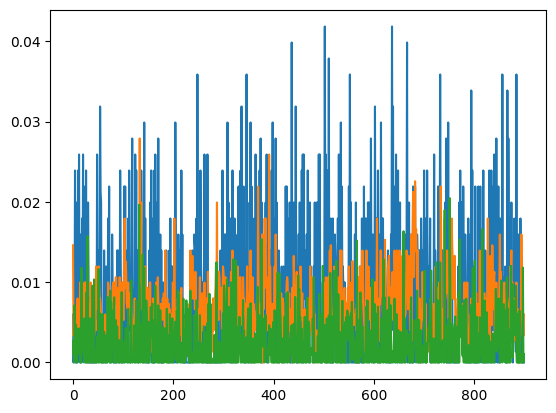

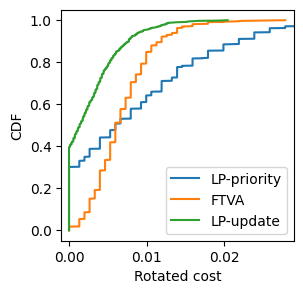

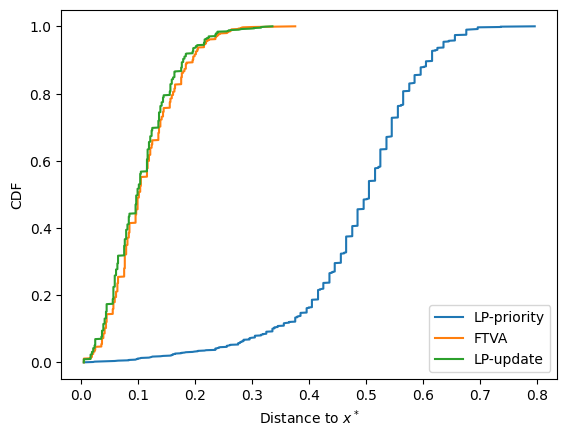

In [28]:
N, seed = 100, 0
Y_prio = strategies.simulate(bandit, lp_prio, x_star, N=N, time=1000, seed=seed)[3]
Y_up = strategies.simulate(bandit, lp_update, x_star, N=N, time=1000, seed=seed)[3]
Y_FTVA = strategies.simulate(bandit, FTVA, x_star, N=N, time=1000, seed=seed)[3]

for Y,label in [(Y_prio, 'LP-priority'), (Y_FTVA, 'FTVA'), (Y_up, 'LP-update')]:
    plt.figure(1)
    plt.plot(bandit.rotated_cost(Y[100:1000], verbose=True), label=label)
    fig=plt.figure(2)
    fig.set_size_inches(3,3)
    plt.plot(np.sort(bandit.rotated_cost(Y)), np.linspace(0, 1, len(bandit.rotated_cost(Y))), label=label)
    plt.xlabel('Rotated cost')
    plt.ylabel('CDF')
    plt.xlim(-0.001, 0.029)
    plt.legend()

    plt.figure(3)
    plt.plot(np.sort(bandit.distance_to_x_star(y=Y)), np.linspace(0, 1, len(bandit.rotated_cost(Y))), label=label)
    plt.xlabel('Distance to $x^*$')
    plt.ylabel('CDF')    
    plt.legend()

plt.figure(2)
plt.savefig('figs/counter-example-GGY{}_CDF_rotated_cost_{}.pdf'.format(EXAMPLE_NUMBER, label), bbox_inches='tight')
plt.figure(3)
plt.savefig('figs/counter-example-GGY{}_CDF_distance_{}.pdf'.format(EXAMPLE_NUMBER, label), bbox_inches='tight')


In [29]:
bandit.x_star

array([0.29943377, 0.33824797, 0.36231826])

**Warning** You may need to run 'pip install python-ternary' for the next plot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


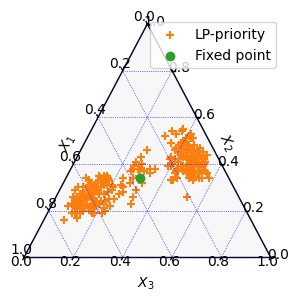

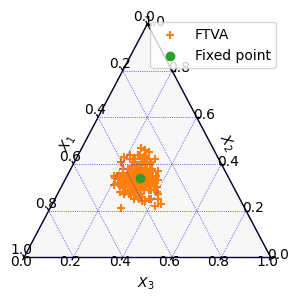

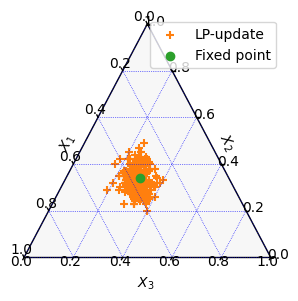

In [30]:
N, seed = 100, 0
X_prio = strategies.simulate(bandit, lp_prio, x_star, N=N, time=1000, seed=seed)[1]
X_up = strategies.simulate(bandit, lp_update, x_star, N=N, time=1000, seed=seed)[1]
X_FTVA = strategies.simulate(bandit, FTVA, x_star, N=N, time=1000, seed=seed)[1]

import ternary

### Scatter Plot
for X,label in [(X_prio, 'LP-priority'), (X_FTVA, 'FTVA'), (X_up, 'LP-update')]:
    figure, tax = ternary.figure(scale=1)
    figure.set_size_inches(3.5,3.5)
    tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=.2, color="blue")
    fontsize=10
    tax.left_axis_label(r"$X_1$", fontsize=fontsize)
    tax.right_axis_label(r"$X_2$" , fontsize=fontsize)
    tax.bottom_axis_label(r"$X_3$", fontsize=fontsize)
    
    # Set ticks
    tax.ticks(axis='lbr', multiple=.2, tick_formats="%.1f", linewidth=1)
    
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.scatter(X[100:400], marker='+', label=label)
    tax.scatter([x_star], marker='o', label='Fixed point')
    tax.legend()
    tax.savefig('figs/counter-example-GGY{}_{}.pdf'.format(EXAMPLE_NUMBER, label), bbox_inches='tight')